# SQL Challenge - Homework 9
## Tools Used
* Postregsql 4 - Type of SQL
* pgAdmin 4 - Database Admin tool
* QuickDBD - Quick Database Diagrams (Tool to create ERD - Entity Relationship Diagrams)
* Jupyter Notebooks - Presentation of work, graphing
* Python, Pandas, MatPlotLib, Numpy, SQL Alchemy - See Imports section

# Data Modeling
## Using the csv files provided, created an ERD in QuickDBD
* departments.csv
* employees.csv
* salaries.csv
* titles.csv
* dept_emp.csv
* dept_manager.csv

![title](ERD-QuickDBD-export.png)

# Data Engineering
### Next, starting from the ERD above, exported a table schema and edited it for specific data types and other constraints such as primary and foreign keys

##### Started with this (export from QuickDBD):
~~~~sql
CREATE TABLE "Departments" (
    "dept_no" VARCHAR(4)   NOT NULL,
    "dept_name" VARCHAR(20)   NOT NULL,
    CONSTRAINT "pk_Departments" PRIMARY KEY (
        "dept_no"
     )
);

CREATE TABLE "Employees" (
    "emp_no" INTEGER   NOT NULL,
    "birth_date" DATE   NOT NULL,
    "first_name" VARCHAR(30)   NOT NULL,
    "last_name" VARCHAR(30)   NOT NULL,
    "gender" CHAR(1)   NOT NULL,
    "hire_date" DATE   NOT NULL,
    CONSTRAINT "pk_Employees" PRIMARY KEY (
        "emp_no"
     )
);

CREATE TABLE "Salaries" (
    "emp_no" INTEGER   NOT NULL,
    "salary" INTEGER   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,
    CONSTRAINT "pk_Salaries" PRIMARY KEY (
        "emp_no","from_date"
     )
);

CREATE TABLE "Titles" (
    "emp_no" INTEGER   NOT NULL,
    "title" VARCHAR(20)   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,
    CONSTRAINT "pk_Titles" PRIMARY KEY (
        "emp_no","from_date"
     )
);

CREATE TABLE "Dep_Emp" (
    "emp_no" INTEGER   NOT NULL,
    "dept_no" VARCHAR(4)   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,
    CONSTRAINT "pk_Dep_Emp" PRIMARY KEY (
        "emp_no","dept_no"
     )
);

CREATE TABLE "Dep_Manager" (
    "emp_no" INTEGER   NOT NULL,
    "dept_no" VARCHAR(4)   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,
    CONSTRAINT "pk_Dep_Manager" PRIMARY KEY (
        "emp_no","dept_no"
     )
);

ALTER TABLE "Salaries" ADD CONSTRAINT "fk_Salaries_emp_no" FOREIGN KEY("emp_no")
REFERENCES "Employees" ("emp_no");

ALTER TABLE "Titles" ADD CONSTRAINT "fk_Titles_emp_no" FOREIGN KEY("emp_no")
REFERENCES "Employees" ("emp_no");

ALTER TABLE "Dep_Emp" ADD CONSTRAINT "fk_Dep_Emp_emp_no" FOREIGN KEY("emp_no")
REFERENCES "Employees" ("emp_no");

ALTER TABLE "Dep_Emp" ADD CONSTRAINT "fk_Dep_Emp_dept_no" FOREIGN KEY("dept_no")
REFERENCES "Departments" ("dept_no");

ALTER TABLE "Dep_Manager" ADD CONSTRAINT "fk_Dep_Manager_emp_no" FOREIGN KEY("emp_no")
REFERENCES "Employees" ("emp_no");

ALTER TABLE "Dep_Manager" ADD CONSTRAINT "fk_Dep_Manager_dept_no" FOREIGN KEY("dept_no")
REFERENCES "Departments" ("dept_no");
~~~~

##### Then updated it to this:
~~~~sql
CREATE TABLE "Departments" (
    -- Create fields
    "dept_no" VARCHAR(4)  NOT NULL,
    "dept_name" VARCHAR(20) NOT NULL,

    -- Add contstraints
    CONSTRAINT "pk_Departments" PRIMARY KEY ("dept_no")
);

CREATE TABLE "Employees" (
    -- Create fields
    "emp_no" INTEGER   NOT NULL,
    "birth_date" DATE   NOT NULL,
    "first_name" VARCHAR(30)   NOT NULL,
    "last_name" VARCHAR(30)   NOT NULL,
    "gender" CHAR(1)   NOT NULL,
    "hire_date" DATE   NOT NULL,

    -- Add constraints
    CONSTRAINT "pk_Employees" PRIMARY KEY ("emp_no")
);

CREATE TABLE "Salaries" (
    -- Create fields
    "emp_no" INTEGER   NOT NULL,
    "salary" INTEGER   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,

    -- Add constraints
    CONSTRAINT "fk_Salaries_emp_no" FOREIGN KEY("emp_no") REFERENCES "Employees" ("emp_no"),
    CONSTRAINT "pk_Salaries" PRIMARY KEY ("emp_no","from_date")
);

CREATE TABLE "Titles" (
    -- Create fields
    "emp_no" INTEGER   NOT NULL,
    "title" VARCHAR(20)   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,

    -- Add constraints
    CONSTRAINT "fk_Titles_emp_no" FOREIGN KEY("emp_no") REFERENCES "Employees" ("emp_no"),
    CONSTRAINT "pk_Titles" PRIMARY KEY ("emp_no","from_date")
);

CREATE TABLE "Dep_Emp" (
    -- Create fields
    "emp_no" INTEGER   NOT NULL,
    "dept_no" VARCHAR(4)   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,

    -- Add constraints
    CONSTRAINT "fk_Dep_Emp_emp_no" FOREIGN KEY("emp_no") REFERENCES "Employees" ("emp_no"),
    CONSTRAINT "fk_Dep_Emp_dept_no" FOREIGN KEY("dept_no") REFERENCES "Departments" ("dept_no"),
    CONSTRAINT "pk_Dep_Emp" PRIMARY KEY ("emp_no","dept_no")
);

CREATE TABLE "Dep_Manager" (
    -- Create fields
    "dept_no" VARCHAR(4)   NOT NULL,
    "emp_no" INTEGER   NOT NULL,
    "from_date" DATE   NOT NULL,
    "to_date" DATE   NOT NULL,

    -- Add constraints
    CONSTRAINT "fk_Dep_Manager_dept_no" FOREIGN KEY("dept_no") REFERENCES "Departments" ("dept_no"),
    CONSTRAINT "fk_Dep_Manager_emp_no" FOREIGN KEY("emp_no") REFERENCES "Employees" ("emp_no"),
    CONSTRAINT "pk_Dep_Manager" PRIMARY KEY ("emp_no","dept_no")
);
~~~~

## Using pgAdmin4
*  Created the database (SQLChallenge)
*  Ran the table schema file above to create the tables
*  Imported the csv files into the appropriate tables ensuring that independent tables were run first to avoid conflicts when loading.

# Data Analysis
## Phase 1 - SQL Queries
* Executed within pgAdmin4

NOTE:  Throughout these queries it was unclear if we were to only use current employee data or include historical as well.  When in doubt, it was run both ways noting that current employees have a to_date of 9999-01-01

### 1. List the following details of each employee: employee number, last name, first name, gender, and salary.
~~~~sql
SELECT emp_no AS "Employee Number", last_name AS "Last Name", first_name AS "First Name", gender AS "Gender",
	(
		SELECT "Salaries".salary
	 	FROM "Salaries"
	 	WHERE "Employees".emp_no = "Salaries".emp_no
	) AS "Salary" 
FROM "Employees";
~~~~
![title](Output/Question1.png)



### 2. List employees who were hired in 1986.
~~~~sql
SELECT emp_no AS "Employee Number", last_name AS "Last Name", first_name AS "First Name", hire_date AS "Hire Date"
FROM "Employees"
WHERE EXTRACT(year FROM hire_date) = 1986;
~~~~
![title](Output/Question2.png)



### 3. List the manager of each department with the following information: 
* department number, department name, the manager's employee number, last name, first name, and start and end employment dates.

#### QUESTION:  List the Complete History or just the current managers?
#### Here is the HISTORY
~~~~sql
SELECT dpt.dept_no AS "Department Number", dpt.dept_name AS "Department Name", dptMgr.emp_no AS "Manager Number", 
    emp.last_name AS "Last Name", emp.first_name AS "First Name", dptMgr.from_date AS "Start Date", 
    dptMgr.to_date AS "End Date"
FROM "Departments" AS dpt, "Dep_Manager" AS dptMgr, "Employees" AS emp
WHERE dpt.dept_no = dptMgr.dept_no AND dptMgr.emp_no = emp.emp_no;
~~~~
![title](Output/Question3History.png)



#### Here is just the current
~~~~sql
SELECT dpt.dept_no AS "Department Number", dpt.dept_name AS "Department Name", dptMgr.emp_no AS "Manager Number",
    emp.last_name AS "Last Name", emp.first_name AS "First Name", dptMgr.from_date AS "Start Date", 
    dptMgr.to_date AS "End Date"
FROM "Departments" AS dpt, "Dep_Manager" AS dptMgr, "Employees" AS emp
WHERE dpt.dept_no = dptMgr.dept_no AND dptMgr.emp_no = emp.emp_no AND EXTRACT(year FROM dptMgr.to_date)=9999;
~~~~
![title](Output/Question3Current.png)



### 4. List the department of each employee with the following information: employee number, last name, first name, and department name.
#### QUESTION:  Is this currently or ever?
#### Here is the History
~~~~sql
SELECT emp.emp_no AS "Employee Number", emp.last_name AS "Last Name", emp.first_name AS "First Name", 
    dpt.dept_name AS "Department Name"
FROM "Departments" AS dpt, "Dep_Emp" AS dptEmp, "Employees" AS emp
WHERE dpt.dept_no = dptEmp.dept_no AND dptEmp.emp_no = emp.emp_no;
~~~~
![title](Output/Question4History.png)



#### Here is current
~~~~sql
SELECT emp.emp_no AS "Employee Number", emp.last_name AS "Last Name", emp.first_name AS "First Name", 
    dpt.dept_name AS "Department Name"
FROM "Departments" AS dpt, "Dep_Emp" AS dptEmp, "Employees" AS emp
WHERE dpt.dept_no = dptEmp.dept_no AND dptEmp.emp_no = emp.emp_no  AND EXTRACT(year FROM dptEmp.to_date)=9999;

~~~~
![title](Output/Question4Current.png)



### 5. List all employees whose first name is "Hercules" and last names begin with "B."
~~~~sql
SELECT emp_no AS "Employee Number", first_name AS "First Name", last_name AS "Last Name"
FROM "Employees"
WHERE first_name = 'Hercules' and last_name LIKE 'B%';
~~~~
![title](Output/Question5.png)



### 6. List all employees in the Sales department, including their employee number, last name, first name, and department name.
#### QUESTION:  Is this currently or ever?
#### Here is the History
~~~~sql
SELECT emp.emp_no AS "Employee Number", emp.last_name AS "Last Name", emp.first_name AS "First Name", 
    dpt.dept_name AS "Department Name"
FROM "Employees" AS emp, "Departments" AS dpt, "Dep_Emp" AS dptEmp
WHERE dpt.dept_no = dptEmp.dept_no AND dptEmp.emp_no = emp.emp_no AND dpt.dept_name = 'Sales';
~~~~
![title](Output/Question6History.png)



#### Here is the current
~~~~sql
SELECT emp.emp_no AS "Employee Number", emp.last_name AS "Last Name", emp.first_name AS "First Name", 
    dpt.dept_name AS "Department Name"
FROM "Employees" AS emp, "Departments" AS dpt, "Dep_Emp" AS dptEmp
WHERE dpt.dept_no = dptEmp.dept_no AND dptEmp.emp_no = emp.emp_no AND dpt.dept_name = 'Sales' AND EXTRACT(year FROM dptEmp.to_date)=9999;
~~~~
![title](Output/Question6Current.png)

  

### 7. List all employees in the Sales and Development departments, including their employee number, last name, first name, and department name
#### QUESTION:  Is this currently or ever?
#### Here is the History
~~~~sql
SELECT emp.emp_no AS "Employee Number", emp.last_name AS "Last Name", emp.first_name AS "First Name", 
    dpt.dept_name AS "Department Name"
FROM "Employees" AS emp, "Departments" AS dpt, "Dep_Emp" AS dptEmp
WHERE dpt.dept_no = dptEmp.dept_no AND dptEmp.emp_no = emp.emp_no AND (dpt.dept_name = 'Sales' OR dpt.dept_name = 'Development');
~~~~
![title](Output/Question7History.png)



#### Here is the current
~~~~sql
SELECT emp.emp_no AS "Employee Number", emp.last_name AS "Last Name", emp.first_name AS "First Name", 
    dpt.dept_name AS "Department Name"
FROM "Employees" AS emp, "Departments" AS dpt, "Dep_Emp" AS dptEmp
WHERE dpt.dept_no = dptEmp.dept_no AND dptEmp.emp_no = emp.emp_no AND (dpt.dept_name = 'Sales' OR dpt.dept_name = 'Development') AND EXTRACT(year FROM dptEmp.to_date)=9999;
~~~~
![title](Output/Question7Current.png)



### 8. In descending order, list the frequency count of employee last names, i.e., how many employees share each last name.
~~~~sql
SELECT last_name AS "Last Name", COUNT(last_name) AS "Count"
FROM "Employees"
GROUP BY last_name
ORDER BY "Count" DESC;
~~~~
![title](Output/Question8.png)

## Phase 2 - Graphical Analysis
### Imports
#### Pandas
Data manipulation and analysis

#### MatPlotLib Pyplot
2D plotting

#### Datetime
Dates and time

#### Numpy
Supports large, multi-dimensional arrays and matrix manipulation and high level mathematical functions on these arrays

#### SQLAlchemy
Database Import

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib
from matplotlib import style
style.use('seaborn')

import datetime

import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import psycopg2

# Import db pw
from keys import pw

### Reusable References

In [2]:
BOLD = '\033[1m'
END = '\033[0m'

### Create the Database Connection

In [22]:
#db_uri = 'postgresql//bootcamp@localhost:5432/SQLChallenge?client_encoding=utf8'
engine = create_engine('postgresql://katro:' + pw + '@localhost:5432/SQLChallenge')

#engine = create_engine(db_uri)
connection = engine.connect()

In [23]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['Employees', 'Salaries', 'Titles', 'Dep_Emp', 'Departments', 'Dep_Manager']

In [24]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('Titles')
for c in columns:
    print(c['name'], c["type"])

emp_no INTEGER
title VARCHAR(20)
from_date DATE
to_date DATE


In [25]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('Salaries')
for c in columns:
    print(c['name'], c["type"])

emp_no INTEGER
salary INTEGER
from_date DATE
to_date DATE


In [26]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
titles_ref = Base.classes.Titles
salaries_ref = Base.classes.Salaries

# Start a session to query the database
session = Session(engine)

In [27]:
# Query tables and store results
title_res = session.query(titles_ref.emp_no, titles_ref.to_date, titles_ref.title).all()
title_res

salary_res = session.query(salaries_ref.emp_no, salaries_ref.salary).all()
salary_res

[(10001, 60117),
 (10002, 65828),
 (10003, 40006),
 (10004, 40054),
 (10005, 78228),
 (10006, 40000),
 (10007, 56724),
 (10008, 46671),
 (10009, 60929),
 (10010, 72488),
 (10011, 42365),
 (10012, 40000),
 (10013, 40000),
 (10014, 46168),
 (10015, 40000),
 (10016, 70889),
 (10017, 71380),
 (10018, 55881),
 (10019, 44276),
 (10020, 40000),
 (10021, 55025),
 (10022, 40000),
 (10023, 47883),
 (10024, 83733),
 (10025, 40000),
 (10026, 47585),
 (10027, 40000),
 (10028, 48859),
 (10029, 63163),
 (10030, 66956),
 (10031, 40000),
 (10032, 48426),
 (10033, 51258),
 (10034, 47561),
 (10035, 41538),
 (10036, 42819),
 (10037, 40000),
 (10038, 40000),
 (10039, 40000),
 (10040, 52153),
 (10041, 56893),
 (10042, 81662),
 (10043, 49324),
 (10044, 40919),
 (10045, 41971),
 (10046, 40000),
 (10047, 54982),
 (10048, 40000),
 (10049, 40000),
 (10050, 74366),
 (10051, 48817),
 (10052, 57212),
 (10053, 67854),
 (10054, 40000),
 (10055, 80024),
 (10056, 48857),
 (10057, 49616),
 (10058, 52787),
 (10059, 71218

In [40]:
sql_statement = 'SELECT t.title AS "Title", AVG(s.salary) AS "Avg Salary" FROM "Titles" AS t, "Salaries" AS s WHERE t.emp_no = s.emp_no AND EXTRACT(year FROM t.to_date)=9999 GROUP BY t.title ORDER BY "Avg Salary"'
    
query_result = pd.read_sql_query(sql_statement, connection)
query_result

,Title,Avg Salary
0,Assistant Engineer,48436.856187
1,Senior Engineer,48501.994322
2,Engineer,48532.428751
3,Technique Leader,48532.833762
4,Manager,49600.555556
5,Staff,58448.920003
6,Senior Staff,58511.960170


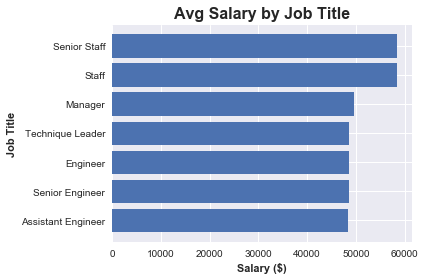

In [46]:
# Create a horizontal bar chart and plot the title on the y-axis and the salary on the x-axis
fig, ax = plt.subplots()
ax.barh(query_result.index, query_result['Avg Salary'])
ax.set_xlabel("Salary ($)", weight='bold')
ax.set_ylabel("Job Title", weight='bold')
ax.set_yticks(query_result.index)
ax.set_yticklabels(query_result['Title'])
ax.set_title("Avg Salary by Job Title", weight='bold', size=16)
fig.tight_layout()
plt.show()

# This code will be replaced with accessing the database

In [ ]:
# Import Employees, Titles and Salaries csv's
emp_csv = './data/employees.csv'
empDateCols = ['birth_date', 'hire_date']
employees = pd.read_csv(emp_csv, parse_dates=empDateCols)

title_csv = './data/titles.csv'
titleDateCols = ['from_date', 'to_date']
titles = pd.read_csv(title_csv, parse_dates=titleDateCols)

sal_csv = './data/salaries.csv'
salaryDateCols = ['from_date', 'to_date']
salaries = pd.read_csv(sal_csv, parse_dates=salaryDateCols)

### Create a bar chart of average salary by title
#### Assumption
* Only include current employee salaries since historic salaries do not represent current day value

#### Start by selecting only current employees

In [ ]:
# Start with the salaries table and select only rows that contain a to_date year of 9999 (indicates current employee)
# First, verify the data types of the to_date column
print(BOLD + 'The to_date column of the salary dataframe is of type:' + END)
print(type(salaries['to_date'].iat[0]))

# Alternatively we can look at all columns at one time
print(BOLD + '\n\nThe data types in the salary dataframe are:' + END)
print(salaries.dtypes)

# Now lets check value_counts
print(BOLD + '\n\nThe value counts for the to_date column are:' + END)
print(salaries['to_date'].value_counts().sort_values(ascending=False))

print(BOLD + 'NOTE: There are no values for the year 9999, so we cannot use this column to determine current employees.' + END)
# We can confirm, however that there are no values by creating a dataframe as well
current_salary = salaries.loc[salaries['to_date'].dt.year==9999,:]
print(BOLD + '\n\nThe results of searching for to_date values in the year 9999 are as expected with no returned values:' + END)
print(current_salary)

print(BOLD + 'NOTE:  The dataframe is empty which aligns with our expectations' + END)

In [ ]:
# Results above show that not all to_date columns in this database use the same convention
# Instead, lets check the titles table

# we can look at all columns at one time to check for datatypes
print(BOLD + 'The data types in the titles dataframe are:' + END)
print(titles.dtypes)
print(BOLD + 'NOTE:  The to_date column would not convert to datetime' + END)

# Now lets check value_counts
print(BOLD + '\n\nThe value counts for the to_date column are:' + END)
print(titles['to_date'].value_counts(ascending=True))
print(BOLD + 'NOTE:  There are roughly 24k employees currently.' + END)

# NOTE - The titles table to_date column will not come in as a date, therefore we perform a string compare
print(BOLD + "\n\nTitles dataframe filtered for current employees (to_date = 9999-01-01):" + END)
titles['to_date'].value_counts(ascending=False)
current_title = titles.loc[titles['to_date'] == '9999-01-01',:]
current_title.head()

#### Now, merge the titles (current employees), employees and salaries dataframes

In [ ]:
# Start with merging employees to current titles
print(BOLD + 'Employees merged with Titles (current employees only)' + END)
emp_title = employees.merge(current_title, on='emp_no')
emp_title.head()

In [ ]:
# Now merge the salaries
print(BOLD + 'Salaries merged with Employees and Titles (current employees only)' + END)
emp_title_salary = emp_title.merge(salaries, on='emp_no').sort_values(['title'], ascending=True).reset_index()

# Finally, let's select only the columns we need
emp_title_salary = emp_title_salary[['title', 'salary']]
emp_title_salary.head()

#### Next, groupby title and create statistics used for graphing

In [ ]:
# groupby title and create relevant statistics on the salary
print(BOLD + 'Salary statistics by Title' + END)
statistics_salary_by_title = emp_title_salary.groupby(['title']).aggregate(
    {
        'salary':['mean', 'median', 'min', 'max', 'count', 'sem']
    }
).sort_values(by=['title'], ascending=True)
statistics_salary_by_title.columns = statistics_salary_by_title.columns.droplevel(0)
statistics_salary_by_title.sort_values(['title'], ascending=True).reset_index()


#### Create a Bar Chart to Show Average Salary by Job Title (and include error bars)

In [ ]:
# Create plot
fig, ax = plt.subplots(figsize=(14,8))
plt.bar(statistics_salary_by_title.index, statistics_salary_by_title['mean'], color='green',
        alpha=0.5, yerr=statistics_salary_by_title['sem'], label='Average Salary ($)')

# Add labels and formatting
plt.xlabel("Job Title", weight='bold', size=12)
plt.ylabel("Annual Salary ($)", weight='bold', size=12)
plt.title("Annual Salary by Job Title", weight='bold', size=22)
plt.xticks(statistics_salary_by_title.index, rotation=90)
plt.legend(loc='best')
plt.grid(alpha=0.2)

# Save the chart out
plt.savefig("./Output/SalaryByTitleBar.png")

# Show plot
plt.show()

#### Interesting... why does Manager have such large error bars?
Let's dig a little more and plot the distributions via a box plot

#### First, create a function

In [ ]:
# Function comparing populations by Boxplots
def boxPlotCompare(srStaff, staff, mgr, techLdr, eng, srEng, asstEng, title):
    
    # Set the figure size
    fig = plt.figure(figsize=(14,8))
    axBox = fig.add_subplot()
    
    # Show box plots of the data
    box_plot_data=[srStaff, staff, mgr, techLdr, eng, srEng, asstEng]
    plt.boxplot(box_plot_data)
    
    # Format the chart
    plt.title(title, color='k', size=24, weight='bold')
    plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Assistant Engineer', 'Engineer', 'Manager', 'Senior Engineer', 'Senior Staff', 'Staff', 'Technique Leader'])    
    plt.xlabel("Job Title", size=14, weight='bold')
    plt.ylabel("Salary ($)", size=14, weight='bold')

    # Save the chart out
    plt.savefig("./Output/SalaryByTitleBoxPlot.png")

    # Show the chart
    plt.show()
       
    return

#### Next, create a series for each job title

In [ ]:
# Create a salary series for each title
srStaff = emp_title_salary.loc[(emp_title_salary['title']=='Senior Staff'),'salary']
staff = emp_title_salary.loc[(emp_title_salary['title']=='Staff'),'salary']
mgr = emp_title_salary.loc[(emp_title_salary['title']=='Manager'),'salary']
techLdr = emp_title_salary.loc[(emp_title_salary['title']=='Technique Leader'),'salary']
eng = emp_title_salary.loc[(emp_title_salary['title']=='Engineer'),'salary']
srEng = emp_title_salary.loc[(emp_title_salary['title']=='Senior Engineer'),'salary']
asstEng = emp_title_salary.loc[(emp_title_salary['title']=='Assistant Engineer'),'salary']

#### Finally, plot the box plots

In [ ]:
# Plot salaries by title in box plots
boxPlotCompare(asstEng, eng, mgr, srEng, srStaff, staff, techLdr, "Salaries ($) by Job Title - Current Employed")

#### Manager has a small range (25 percentile to 75 percentile) and the fewest outliers, but the largest errors.
Let's dig more...

#### This time, let's look at a scatter plot of the individual data and plot the median as a reference

In [ ]:
# Plot the data
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot()
plt.scatter(emp_title_salary["title"], emp_title_salary["salary"], c="b", alpha=0.5, label='salary')
plt.plot(statistics_salary_by_title.index, statistics_salary_by_title['median'], color='green', label='median')

# format the chart
plt.title(f'Salary ($) vs Job Title - Currently Employed', color='k', size=24, weight='bold')
plt.xlabel('Job Title', weight='bold', size=12)
plt.ylabel('Salary ($)', weight='bold', size=12)
plt.grid(alpha=0.2)
plt.legend(loc='best')

# Save the chart out
plt.savefig("./Output/SalaryByTitleScatterAndMedian.png")

# Show the plot
plt.show()


#### Interesting, there is very little data for Manager so there is a higher spread between points
Let's now check how many data points there are

In [ ]:
# Redisplay the statistics table
print(BOLD + 'Statistics of Salaries by Job Title' + END)
print(statistics_salary_by_title)

print(BOLD + 'NOTE:  Manager only has 9 data points compared to thousands for the other titles.' + END)

## Now, per the last item requested by the boss, look up employee id

#### Look up Employee ID = 499942

In [ ]:
my_info = employees.loc[employees["emp_no"] == 499942, :]
my_info

#### NOTE the fact that suspicians were correct and the data is fake.